# **Maxime's Notebook - Focus on Cycle GAN**

what is a cycle gan ?  
CycleGAN augmentation → Image dataset → Classification model (CNN, ResNet, etc.) → Soil type prediction

In [ ]:
# Install necessary packages

import os
import matplotlib.pyplot as plt
import torchvision
import random
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time
import gc
from tqdm.auto import tqdm

# 📁 Configuration du dossier de sortie (outputs)
# Dans Jupyter, utiliser os.getcwd() qui est le dossier courant d'exécution
# Le dossier outputs sera créé au niveau du parent du dossier notebooks
notebooks_dir = os.getcwd()  # Dossier courant (généralement notebooks/)
parent_dir = os.path.dirname(notebooks_dir)  # Parent du dossier notebooks
OUTPUT_DIR = os.path.join(parent_dir, "results","StarGAN")

# Assurer que OUTPUT_DIR est bien un dossier (si un fichier homonyme existe, le supprimer)
if os.path.exists(OUTPUT_DIR) and not os.path.isdir(OUTPUT_DIR):
    try:
        os.remove(OUTPUT_DIR)
        print(f"⚠️ Fichier supprimé pour libérer le chemin dossier: {OUTPUT_DIR}")
    except Exception as e:
        print(f"⚠️ Impossible de supprimer le fichier {OUTPUT_DIR}: {e}")
        raise
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"📁 Dossier de sortie configuré: {OUTPUT_DIR}\n")


📁 Dossier de sortie configuré: c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs



In [ ]:
# Détermination des nombres d'epoch
num_epochs = 100

In [147]:
## Etape 0 : Initialisation des dossiers

# Vidage du dossier StarGAN-Dataset s'il existe
StarGAN_path = os.path.join(parent_dir, "data", "StarGAN-Dataset")

import shutil

def _on_rm_error(func, path, exc_info):
    import stat
    try:
        os.chmod(path, stat.S_IWRITE)
        func(path)
    except Exception as e:
        print(f"⚠️ Impossible de supprimer {path}: {e}")

if os.path.exists(StarGAN_path):
    try:
        shutil.rmtree(StarGAN_path, onerror=_on_rm_error)
        print(f"🧹 Dossier vidé: {StarGAN_path}")
    except Exception as e:
        print(f"⚠️ Erreur lors du vidage de {StarGAN_path}: {e}")
else:
    print(f"ℹ️ Dossier inexistant (rien à vider): {StarGAN_path}")

# Recréer le dossier pour la suite du pipeline
os.makedirs(StarGAN_path, exist_ok=True)
print(f"📁 Dossier recréé: {StarGAN_path}")


ℹ️ Dossier inexistant (rien à vider): c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\data\StarGAN-Dataset
📁 Dossier recréé: c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\data\StarGAN-Dataset


In [148]:
import os
import shutil
import stat

def remove_readonly(func, path, _):
    os.chmod(path, stat.S_IWRITE)
    func(path)

# Chemins des dossiers
parent_dir = r"../data/Orignal-Dataset"
StarGAN_dir = r"../data/StarGAN-Dataset"

# Vérification de l'existence et des permissions
if not os.path.exists(parent_dir):
    raise FileNotFoundError(f"Le dossier parent '{parent_dir}' n'existe pas.")

os.makedirs(StarGAN_dir, exist_ok=True)

folder_mapping = {
    "Alluvial_Soil": "type1",
    "Arid_Soil": "type2",
    "Black_Soil": "type3",
    "Laterite_Soil": "type4",
    "Mountain_Soil": "type5",
    "Red_Soil": "type6",
    "Yellow_Soil": "type7"
}

for old_name, new_name in folder_mapping.items():
    old_path = os.path.join(parent_dir, old_name)
    new_path = os.path.join(StarGAN_dir, new_name)

    if os.path.exists(old_path):
        if os.path.exists(new_path):
            shutil.rmtree(new_path, onerror=remove_readonly)
        shutil.copytree(old_path, new_path)
        print(f"Copie de '{old_name}' vers '{new_name}' réussie.")
    else:
        print(f"Le dossier '{old_name}' n'existe pas dans '{parent_dir}'.")

print("Copie et renommage des dossiers terminés.")


Copie de 'Alluvial_Soil' vers 'type1' réussie.
Copie de 'Arid_Soil' vers 'type2' réussie.
Copie de 'Black_Soil' vers 'type3' réussie.
Copie de 'Laterite_Soil' vers 'type4' réussie.
Copie de 'Mountain_Soil' vers 'type5' réussie.
Copie de 'Red_Soil' vers 'type6' réussie.
Copie de 'Yellow_Soil' vers 'type7' réussie.
Copie et renommage des dossiers terminés.


In [149]:
## Étape 2 : Conversion des images en .jpg

def convert_images_to_jpg(folder_path):
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                filepath = os.path.join(class_path, file_name)
                # Si l'image n'est pas déjà en .jpg, la convertir
                if os.path.isfile(filepath) and not file_name.lower().endswith('.jpg'):
                    try:
                        img = Image.open(filepath)
                        # Convertir en RGB (au cas où l'image a un canal alpha)
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        # Sauvegarder en .jpg avec le même nom
                        new_filename = os.path.splitext(file_name)[0] + '.jpg'
                        new_filepath = os.path.join(class_path, new_filename)
                        img.save(new_filepath, 'JPEG', quality=95)
                        # Supprimer le fichier original si ce n'est pas déjà du .jpg
                        if file_name != new_filename:
                            os.remove(filepath)
                    except Exception as e:
                        print(f"Erreur avec {file_name}: {e}")

# Convertir les images dans le dossier renommé
convert_images_to_jpg(StarGAN_dir)
print("Conversion des images en .jpg terminée.")


Conversion des images en .jpg terminée.


In [150]:
## Étape 3 : Redimensionner les images à 128x128 pixels

def resize_images_in_folder(folder_path, size=(128, 128)):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img = img.resize(size, Image.LANCZOS)
                img.save(img_path)
            else:
                print(f"Le fichier {file} n'est pas au format .jpg et sera ignoré.")

# Redimensionner les images dans le dossier renommé
resize_images_in_folder(StarGAN_dir)
print("Redimensionnement des images terminé.")

Redimensionnement des images terminé.


In [151]:
## Vérification des nombres d'images par classe

def count_images_in_folder(folder_path):
    count_dict = {}
    for root, dirs, files in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = len([f for f in os.listdir(dir_path)])
            count_dict[dir_name] = count
    return count_dict

parent_counts = count_images_in_folder(StarGAN_dir)
print("\nNombre d'images par classe dans le dossier parent:")
for class_name, count in parent_counts.items():
    print(f"{class_name}: {count} images")


Nombre d'images par classe dans le dossier parent:
type1: 52 images
type2: 284 images
type3: 255 images
type4: 219 images
type5: 201 images
type6: 109 images
type7: 69 images


In [152]:
## Étape 4 : Train/Test split et création des dossiers train et test

# Créer les sous-dossiers pour train et test
for i in range(1, 8):
    os.makedirs(os.path.join(StarGAN_dir, "train", f"type{i}"), exist_ok=True)
    os.makedirs(os.path.join(StarGAN_dir, "test", f"type{i}"), exist_ok=True)

# Répartir les images avec train_test_split
for index, (old_name, new_name) in enumerate(folder_mapping.items()):
    # Si le dossier est vide, on passe au dossier suivant
    if not os.listdir(os.path.join(StarGAN_dir, new_name)):
        print(f"Le dossier {new_name} est vide. Passage à la classe suivante.")
        continue
    class_dir = os.path.join(StarGAN_dir, new_name)
    images = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)

    # Déplacer les images vers les dossiers train et test
    for img in train_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(StarGAN_dir, "train", new_name, img))
    for img in test_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(StarGAN_dir, "test", new_name, img))

    # Supprimer le dossier vide
    #shutil.rmtree(class_dir)

print("Répartition des images terminée.")


Répartition des images terminée.


In [153]:
## Comparaison du nombre d'images dans chaque dossier

train_counts = count_images_in_folder(os.path.join(StarGAN_dir, "train"))
test_counts = count_images_in_folder(os.path.join(StarGAN_dir, "test"))
parent_counts = count_images_in_folder(parent_dir)

print("Nombre d'images par classe dans le dossier 'train':")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nNombre d'images par classe dans le dossier 'test':")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} images")

print("\nNombre d'images par classe dans le dossier parent:")
for class_name, count in parent_counts.items():
    print(f"{class_name}: {count} images")

Nombre d'images par classe dans le dossier 'train':
type1: 36 images
type2: 198 images
type3: 178 images
type4: 153 images
type5: 140 images
type6: 76 images
type7: 48 images

Nombre d'images par classe dans le dossier 'test':
type1: 16 images
type2: 86 images
type3: 77 images
type4: 66 images
type5: 61 images
type6: 33 images
type7: 21 images

Nombre d'images par classe dans le dossier parent:
Alluvial_Soil: 52 images
Arid_Soil: 284 images
Black_Soil: 255 images
Laterite_Soil: 219 images
Mountain_Soil: 201 images
Red_Soil: 109 images
Yellow_Soil: 69 images


In [154]:
# Vérification que train + test = parent (en utilisant folder_mapping pour la correspondance)
print("\nVérification que train + test = parent:")
for old_name, new_name in folder_mapping.items():
    total = train_counts.get(new_name, 0) + test_counts.get(new_name, 0)
    parent_total = parent_counts.get(old_name, 0)
    print(f"{old_name} ({new_name}): train + test = {total}, parent = {parent_total}, égalité: {total == parent_total}")



Vérification que train + test = parent:
Alluvial_Soil (type1): train + test = 52, parent = 52, égalité: True
Arid_Soil (type2): train + test = 284, parent = 284, égalité: True
Black_Soil (type3): train + test = 255, parent = 255, égalité: True
Laterite_Soil (type4): train + test = 219, parent = 219, égalité: True
Mountain_Soil (type5): train + test = 201, parent = 201, égalité: True
Red_Soil (type6): train + test = 109, parent = 109, égalité: True
Yellow_Soil (type7): train + test = 69, parent = 69, égalité: True


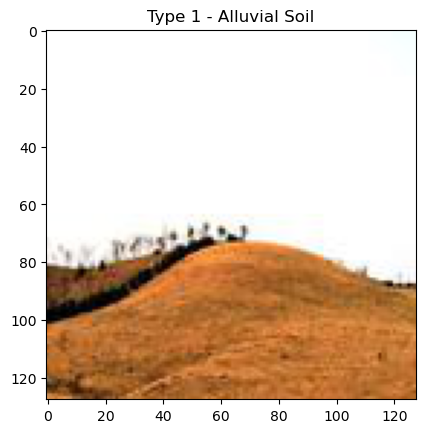

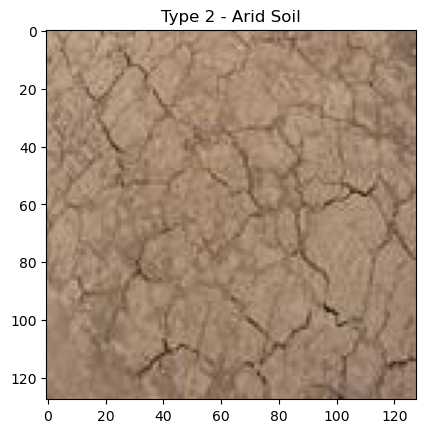

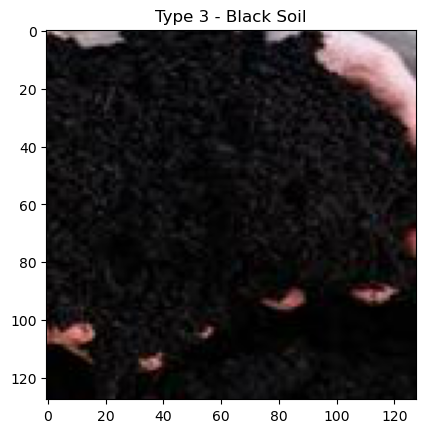

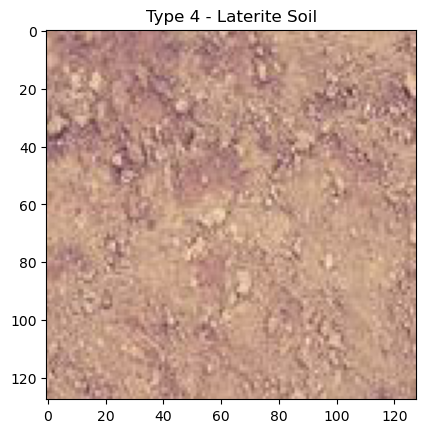

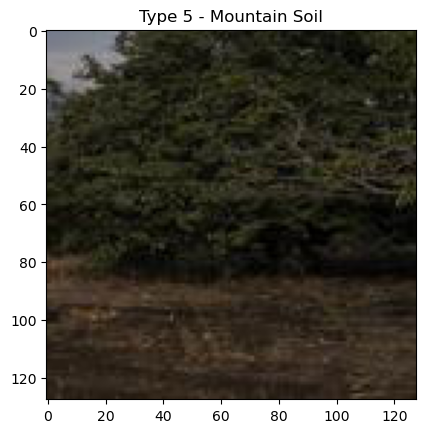

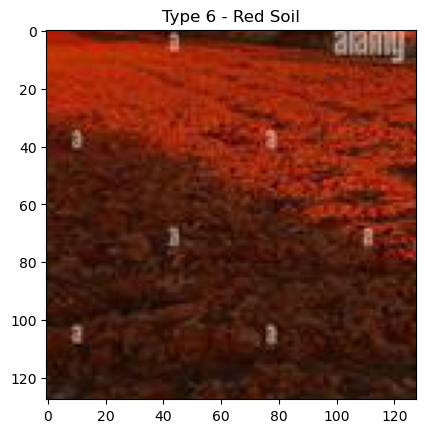

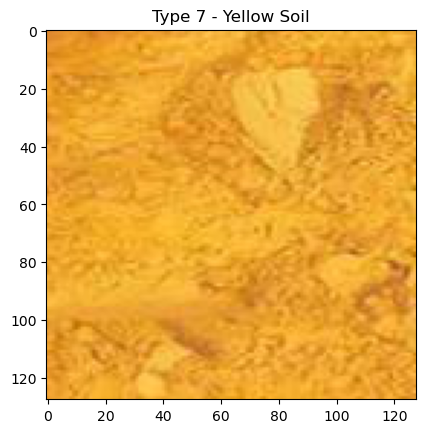

In [155]:
## Affichage d'image aléatoire en affichant le type de sol

# Créer un dictionnaire inversé pour retrouver les noms originaux
inverse_mapping = {v: k for k, v in folder_mapping.items()}

for i in range(1, 8):
    train_dir = os.path.join(StarGAN_dir, "train", f"type{i}")
    sample_img = random.choice(os.listdir(train_dir))
    img_path = os.path.join(train_dir, sample_img)
    img = Image.open(img_path)
    plt.imshow(img)
    soil_name = inverse_mapping[f"type{i}"].replace("_", " ")
    plt.title(f"Type {i} - {soil_name}")
    plt.show()


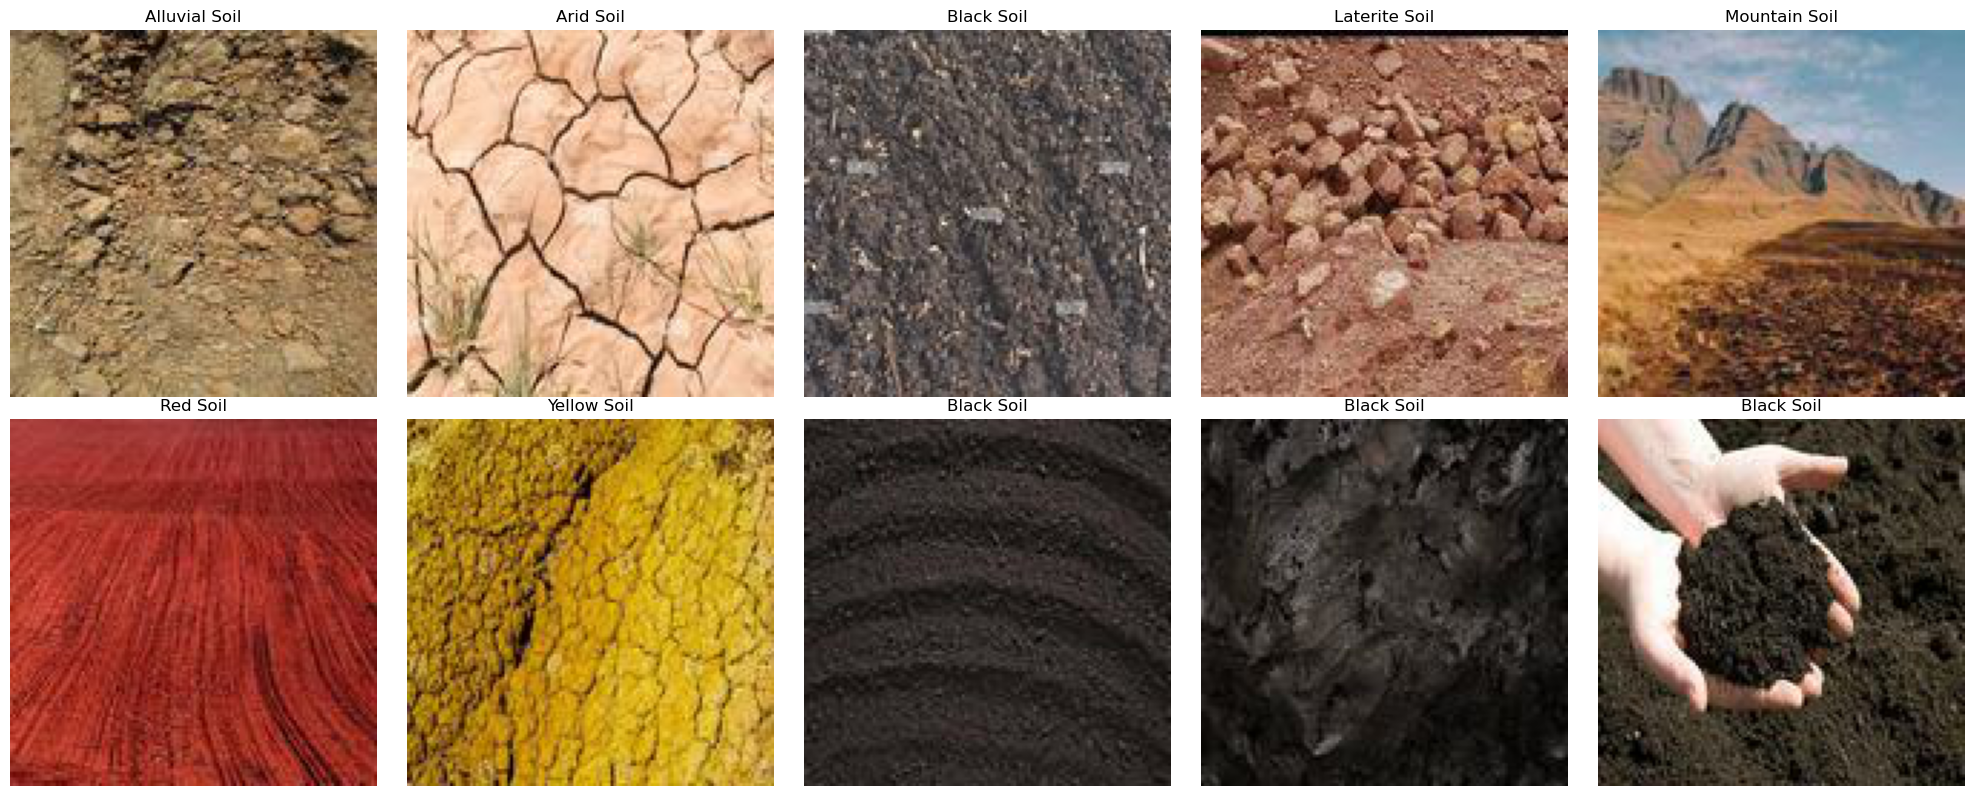

✅ Aperçu sauvegardé dans c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs\initial_samples_overview.png


In [168]:
## Aperçu visuel initial : 10 images (≥1 par classe) sur 2 lignes

import matplotlib.pyplot as plt
from PIL import Image

soil_labels = {
    "type1": "Alluvial Soil",
    "type2": "Arid Soil",
    "type3": "Black Soil",
    "type4": "Laterite Soil",
    "type5": "Mountain Soil",
    "type6": "Red Soil",
    "type7": "Yellow Soil",
}

train_root = os.path.join(StarGAN_dir, "train")
classes = sorted([d for d in os.listdir(train_root) if os.path.isdir(os.path.join(train_root, d))])

# Sélectionner au moins une image par classe, puis compléter jusqu'à 10 images
selected = []
for cls in classes:
    cls_dir = os.path.join(train_root, cls)
    imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith('.jpg')]
    if imgs:
        selected.append((cls, os.path.join(cls_dir, random.choice(imgs))))

# Compléter aléatoirement jusqu'à 10 images
while len(selected) < 10:
    cls = random.choice(classes)
    cls_dir = os.path.join(train_root, cls)
    imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith('.jpg')]
    if not imgs:
        continue
    selected.append((cls, os.path.join(cls_dir, random.choice(imgs))))

# Limiter à 10
selected = selected[:10]

rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for ax, (cls, img_path) in zip(axes, selected):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(soil_labels.get(cls, cls))
    ax.axis('off')

# Désactiver les axes restants si <10 sélectionnées
for ax in axes[len(selected):]:
    ax.axis('off')

plt.tight_layout()
preview_path = os.path.join(OUTPUT_DIR, "initial_samples_overview.png")
plt.savefig(preview_path, dpi=100, bbox_inches='tight')
plt.show()
print(f"✅ Aperçu sauvegardé dans {preview_path}")


In [156]:
## Étape 5 : Création d'une classe Dataset personnalisée

class SolDataset(Dataset):
    def __init__(self, root_dir, transform=None, allowed_domains=None):
        self.transform = transform
        self.images = []
        self.domains = []
        self.domain_names = []

        # Parcourir les sous-dossiers de root_dir (train ou test)
        for domain_idx, domain in enumerate(sorted(os.listdir(root_dir)), start=1):
            domain_path = os.path.join(root_dir, domain)
            # Mémoriser les noms de domaines triés
            self.domain_names.append(domain)
            # Appliquer filtre de domaines si fourni
            if allowed_domains is not None and (domain_idx - 1) not in allowed_domains:
                continue
            for img_name in os.listdir(domain_path):
                self.images.append(os.path.join(domain_path, img_name))
                self.domains.append(domain_idx - 1)  # Les labels commencent à 0

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        domain = self.domains[index]
        if self.transform:
            img = self.transform(img)
        return img, domain

    def __len__(self):
        return len(self.images)


In [157]:
## Étape 6.1 : Définir les transformations

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionner à 128x128
    transforms.ToTensor(),          # Convertir en tenseur
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliser entre -1 et 1
])

In [158]:
## Etape 6.2 : Créer les datasets et dataloaders

# Identifier les domaines riches (beaucoup d'images) et exclure le domaine cible appauvri (Alluvial = type1)
train_root = os.path.join(StarGAN_dir, "train")
counts = {}
for d in sorted(os.listdir(train_root)):
    counts[d] = len(os.listdir(os.path.join(train_root, d)))

# Définir type1 (Alluvial_Soil) comme domaine cible appauvri
target_domain_name = "type1"
rich_domains_names = [d for d, c in counts.items() if d != target_domain_name and c > 50]  # seuil ajustable
name_to_index = {f"type{i}": i-1 for i in range(1,8)}
allowed_domains = [name_to_index[n] for n in rich_domains_names]

train_dataset = SolDataset(train_root, transform=transform, allowed_domains=allowed_domains)
test_dataset = SolDataset(os.path.join(StarGAN_dir, "test"), transform=transform)

# DataLoader - num_workers=0 pour éviter les problèmes Windows/Jupyter
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("Domaines riches utilisés pour source:", rich_domains_names)
print("Taille du train_dataset:", len(train_dataset))

Domaines riches utilisés pour source: ['type2', 'type3', 'type4', 'type5', 'type6']
Taille du train_dataset: 745


In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.backends.cudnn.benchmark = True

## Etape 7.1 : Définition du générateur et du discriminateur

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, num_domains=5, dim=32, num_res_blocks=3):
        super(Generator, self).__init__()
        self.dim = dim
        # Couches initiales
        self.conv1 = nn.Conv2d(3, dim, 7, 1, 3)
        self.norm1 = nn.InstanceNorm2d(dim)

        # Blocs résiduels
        self.res_blocks = nn.Sequential(*[ResidualBlock(dim) for _ in range(num_res_blocks)])

        # Couche pour intégrer le vecteur de domaine
        self.domain_embedding = nn.Sequential(
            nn.Linear(num_domains, dim * 256),
            nn.ReLU(inplace=True),
            nn.Linear(dim * 256, dim),
            nn.ReLU(inplace=True)
        )

        # Couches finales
        self.conv2 = nn.Conv2d(dim, 3, 7, 1, 3)

    def forward(self, x, domain):
        # Encoder l'image
        x = F.relu(self.norm1(self.conv1(x)))

        # Passer par les blocs résiduels
        x = self.res_blocks(x)

        # Intégrer le vecteur de domaine (broadcasting sur les canaux)
        domain_embedding = self.domain_embedding(domain)  # Shape: (batch_size, dim)
        domain_embedding = domain_embedding.view(-1, self.dim, 1, 1)  # Reshape: (batch_size, dim, 1, 1)
        x = x + domain_embedding  # Broadcasting automatique sur les dimensions spatiales

        # Décoder l'image
        return torch.tanh(self.conv2(x))

class Discriminator(nn.Module):
    def __init__(self, num_domains=5, dim=32):
        super(Discriminator, self).__init__()
        # Couches initiales
        self.conv1 = nn.Conv2d(3, dim, 4, 2, 1)
        self.conv2 = nn.Conv2d(dim, dim * 2, 4, 2, 1)
        self.norm2 = nn.InstanceNorm2d(dim * 2)

        # Couches pour la prédiction adversariale (réelle/fausse)
        self.adv_layer = nn.Conv2d(dim * 2, 1, 3, 1, 1)

        # Couches pour la prédiction de domaine (avec global pooling)
        self.domain_conv = nn.Conv2d(dim * 2, num_domains, 3, 1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Extraire les caractéristiques
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.norm2(self.conv2(x)), 0.2)

        # Prédiction adversariale
        adv_out = self.adv_layer(x)

        # Prédiction de domaine avec global pooling
        domain_features = self.domain_conv(x)
        domain_out = self.global_pool(domain_features)
        domain_out = domain_out.view(domain_out.size(0), -1)  # (batch, num_domains)

        return adv_out, domain_out

In [160]:
## Étape 7.2 : Initialiser le générateur et le discriminateur

num_domains = 7  # Vous avez 7 types de sols

# Vérifier si CUDA est disponible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Utilisation du device: {device}")

G = Generator(num_domains).to(device)
D = Discriminator(num_domains).to(device)


Utilisation du device: cpu


In [161]:
## Etape 7.3 : Définir les fonctions de perte, les optimisateurs et les scalers AMP

loss_bce = nn.BCEWithLogitsLoss()
loss_ce = nn.CrossEntropyLoss()
loss_l1 = nn.L1Loss()

optim_G = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Mixed precision (AMP)
scaler_G = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
scaler_D = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

C:\Users\maxde\AppData\Local\Temp\ipykernel_19004\109480381.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\maxde\AppData\Local\Temp\ipykernel_19004\109480381.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [162]:
def get_class_distribution(root_dir):
    """
    Calcule le nombre d'images par classe (type1-type7) dans un dossier.
    """
    class_counts = {}
    for class_dir in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
            class_counts[class_dir] = count
    return class_counts


def save_sample_images(G, real_images, target_domain, epoch, device, num_domains):
    """
    Generate and save sample images from the generator for visualization.
    Sauvegarde dans SAMPLE_DIR si disponible, sinon dans OUTPUT_DIR/samples.
    """
    with torch.no_grad():
        target_domain_one_hot = F.one_hot(target_domain[:4], num_domains).float().to(device)
        sample_images = G(real_images[:4], target_domain_one_hot)
        # Résoudre le dossier d'échantillons de manière robuste
        try:
            sample_dir = globals().get('SAMPLE_DIR', None)
            if sample_dir is None:
                sample_dir = os.path.join(globals().get('OUTPUT_DIR', '.'), 'samples')
        except Exception:
            sample_dir = 'samples'
        os.makedirs(sample_dir, exist_ok=True)
        sample_path = os.path.join(sample_dir, f"epoch_{epoch}.png")
        torchvision.utils.save_image(sample_images, sample_path, normalize=True, nrow=2)


def generate_images_for_class(G, loader, device, num_domains, target_class_idx, out_dir, max_images):
    """
    Génère des images synthétiques pour une classe cible spécifique.
    Utilise les images des autres domaines comme source pour la traduction.
    """
    os.makedirs(out_dir, exist_ok=True)
    G.eval()
    generated = 0
    with torch.no_grad():
        for b_idx, (real_images, source_domain) in enumerate(loader):
            if generated >= max_images:
                break
            real_images = real_images.to(device, non_blocking=True)
            # Cible fixe: la classe spécifiée
            target_domain = torch.full((real_images.size(0),), target_class_idx, dtype=torch.long, device=device)
            target_one_hot = F.one_hot(target_domain, num_domains).float().to(device)
            fake_images = G(real_images, target_one_hot)
            for i in range(fake_images.size(0)):
                if generated >= max_images:
                    break
                out_path = os.path.join(out_dir, f"aug_gen_{generated:04d}.jpg")
                torchvision.utils.save_image(fake_images[i], out_path, normalize=True)
                generated += 1
    print(f"Images générées pour la classe {target_class_idx}: {generated} images")
    G.train()
    return generated


def class_equalizer(G, loader, device, num_domains, train_dir, classification_dir):
    """
    Équilibre le nombre d'images pour chaque classe en générant des images synthétiques.
    Les images générées sont sauvegardées dans les dossiers train de chaque classe.
    """
    # Compter les images actuelles dans le dossier train
    class_counts = get_class_distribution(train_dir)
    
    print("\n" + "="*60)
    print("🔄 ÉQUILIBRAGE DES CLASSES (CLASS EQUALIZER)")
    print("="*60)
    print("Distribution initiale des images par classe:")
    for class_name, count in sorted(class_counts.items()):
        print(f"  {class_name}: {count} images")
    
    # Trouver le maximum
    max_count = max(class_counts.values())
    print(f"\n📊 Classe avec le plus d'images: {max_count} images")
    
    # Générer les images manquantes pour chaque classe
    total_generated = 0
    for class_idx in range(num_domains):
        class_name = f"type{class_idx + 1}"
        current_count = class_counts.get(class_name, 0)
        images_needed = max_count - current_count
        
        if images_needed > 0:
            print(f"\n🎯 Génération pour {class_name}: {images_needed} images manquantes")
            class_out_dir = os.path.join(train_dir, class_name)
            generated = generate_images_for_class(
                G, loader, device, num_domains, 
                class_idx, class_out_dir, images_needed
            )
            total_generated += generated
        else:
            print(f"✅ {class_name}: {current_count} images (maximum atteint)")
    
    # Vérification finale
    print("\n" + "="*60)
    print("✨ VÉRIFICATION FINALE")
    print("="*60)
    final_counts = get_class_distribution(train_dir)
    for class_name, count in sorted(final_counts.items()):
        print(f"  {class_name}: {count} images")
    
    # Copier les images équilibrées dans le dossier classification_dataset
    print("\n📁 Copie des images équilibrées vers le dataset de classification…")
    for class_idx in range(1, num_domains + 1):
        class_name = f"type{class_idx}"
        src = os.path.join(train_dir, class_name)
        dst = os.path.join(classification_dir, "train", class_name)
        os.makedirs(dst, exist_ok=True)
        
        # Copier tous les fichiers
        for img_file in os.listdir(src):
            if img_file.endswith('.jpg'):
                shutil.copy(os.path.join(src, img_file), os.path.join(dst, img_file))
    
    print("✅ Dataset de classification mis à jour avec les images équilibrées!")
    print(f"Total d'images générées: {total_generated}")
    print("="*60 + "\n")


In [163]:
## Etape 8.1 : Définir la boucle d'entraînement

def train_step(real_images, source_domain, target_domain, scaler_G, scaler_D, use_amp=True):
    # Transfert GPU (avec non_blocking si possible)
    real_images = real_images.to(device, non_blocking=True)
    source_domain = source_domain.to(device, non_blocking=True)
    target_domain = target_domain.to(device, non_blocking=True)

    # Génération des images synthétiques + calculs dans autocast
    with torch.cuda.amp.autocast(enabled=use_amp):
        target_domain_one_hot = F.one_hot(target_domain, num_domains).float().to(device)
        fake_images = G(real_images, target_domain_one_hot)

        # Discriminateur
        real_pred, real_domain_pred = D(real_images)
        fake_pred, fake_domain_pred = D(fake_images.detach())
        ones = torch.ones_like(fake_pred)

        loss_D_adv = loss_bce(fake_pred - real_pred.mean(0), ones)
        loss_D_domain_real = loss_ce(real_domain_pred, source_domain)
        loss_D_domain_fake = loss_ce(fake_domain_pred, target_domain)
        loss_D = loss_D_adv + loss_D_domain_real + loss_D_domain_fake

    # Mise à jour du discriminateur
    optim_D.zero_grad(set_to_none=True)
    scaler_D.scale(loss_D).backward()
    scaler_D.step(optim_D)
    scaler_D.update()

    # Générateur (recalcule prédiction adversariale et reconstruction)
    with torch.cuda.amp.autocast(enabled=use_amp):
        fake_pred, fake_domain_pred = D(fake_images)
        loss_G_adv = loss_bce(fake_pred, ones)
        loss_G_domain = loss_ce(fake_domain_pred, target_domain)

        source_domain_one_hot = F.one_hot(source_domain, num_domains).float().to(device)
        reconstructed_images = G(fake_images, source_domain_one_hot)
        loss_G_rec = loss_l1(reconstructed_images, real_images)
        RECONSTRUCTION_LOSS_WEIGHT = 10
        loss_G = loss_G_adv + loss_G_domain + RECONSTRUCTION_LOSS_WEIGHT * loss_G_rec

    optim_G.zero_grad(set_to_none=True)
    scaler_G.scale(loss_G).backward()
    scaler_G.step(optim_G)
    scaler_G.update()

    return {
        "loss_D": loss_D.item(),
        "loss_G": loss_G.item(),
        "loss_D_adv": loss_D_adv.item(),
        "loss_G_adv": loss_G_adv.item(),
        "loss_G_rec": loss_G_rec.item(),
    }

In [164]:
# Configuration
import csv

num_domains = 7
SAVE_INTERVAL = 10
SAMPLE_DIR = os.path.join(OUTPUT_DIR, "samples")
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")
BASE_LOG_DIR = os.path.join(OUTPUT_DIR, "training_logs")
RUN_ID = time.strftime('%Y%m%d-%H%M%S')
LOG_DIR = os.path.join(BASE_LOG_DIR, RUN_ID)
LOG_EVERY_N = 5
USE_TENSORBOARD = False  # Désactiver TensorBoard si problème persistant

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"📊 Configuration des dossiers de sortie:")
print(f"  • OUTPUT_DIR: {OUTPUT_DIR}  → {'dir' if os.path.isdir(OUTPUT_DIR) else 'file' if os.path.exists(OUTPUT_DIR) else 'missing'}")
print(f"  • Samples:   {SAMPLE_DIR}")
print(f"  • Models:    {MODEL_DIR}")
print(f"  • Logs:      {LOG_DIR} (RUN_ID={RUN_ID})\n")

# 🔧 S'assurer que OUTPUT_DIR est bien un dossier (pas un fichier)
try:
    if os.path.exists(OUTPUT_DIR) and not os.path.isdir(OUTPUT_DIR):
        print(f"⚠️ '{OUTPUT_DIR}' existe mais n'est pas un dossier. Suppression…")
        os.remove(OUTPUT_DIR)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
except Exception as e:
    print(f"⚠️ Impossible d'assurer la création de {OUTPUT_DIR}: {e}")
    raise

# 🔥 IMPORTANT: Fermer tous les writers TensorBoard existants AVANT de supprimer
try:
    if 'writer' in globals() and writer is not None:
        writer.close()
        del writer
        print("Writer TensorBoard précédent fermé")
    time.sleep(0.5)  # Laisser à Windows le temps de libérer les fichiers
except Exception as e:
    print(f"Pas de writer à fermer: {e}")

# Nettoyage sélectif (on garde BASE_LOG_DIR, on crée un sous-dossier par run)
gc.collect()
for folder in [SAMPLE_DIR, MODEL_DIR]:
    max_attempts = 5
    for attempt in range(max_attempts):
        try:
            if os.path.exists(folder):
                if os.path.isfile(folder):
                    os.remove(folder)
                elif os.path.isdir(folder):
                    shutil.rmtree(folder, onerror=remove_readonly)
            break
        except Exception as e:
            if attempt < max_attempts - 1:
                print(f"Tentative {attempt+1}/{max_attempts} échouée pour {folder}, nouvelle tentative…")
                time.sleep(2)
                gc.collect()
            else:
                print(f"⚠️ Impossible de supprimer {folder} après {max_attempts} tentatives: {e}")
                print(f"Solution: Redémarrez le kernel (Kernel > Restart Kernel) puis réexécutez")
                raise

# (Re)création des dossiers nécessaires
os.makedirs(SAMPLE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(BASE_LOG_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# --- Logger unifié: TensorBoard (optionnel) + CSV ---
writer = None
if USE_TENSORBOARD:
    try:
        writer = SummaryWriter(log_dir=LOG_DIR)
        print(f"✅ TensorBoard initialisé dans {LOG_DIR}")
    except Exception as e:
        writer = None
        print(f"⚠️ TensorBoard indisponible ({e}). Fallback CSV uniquement.")

LOG_CSV_PATH = os.path.join(LOG_DIR, "metrics.csv")
if not os.path.exists(LOG_CSV_PATH):
    with open(LOG_CSV_PATH, 'w', newline='') as f:
        csv.writer(f).writerow([
            'step', 'loss_D', 'loss_G', 'loss_D_adv', 'loss_G_adv', 'loss_G_rec'
        ])
print(f"📝 CSV logging → {LOG_CSV_PATH}")


def log_metrics(step: int, losses: dict):
    # CSV
    try:
        with open(LOG_CSV_PATH, 'a', newline='') as f:
            csv.writer(f).writerow([
                step,
                losses.get('loss_D'),
                losses.get('loss_G'),
                losses.get('loss_D_adv'),
                losses.get('loss_G_adv'),
                losses.get('loss_G_rec'),
            ])
    except Exception as e:
        print(f"⚠️ Échec écriture CSV: {e}")
    # TensorBoard (si actif)
    if writer is not None:
        try:
            writer.add_scalar("Loss/Discriminator", losses["loss_D"], step)
            writer.add_scalar("Loss/Generator", losses["loss_G"], step)
            writer.add_scalar("Loss/D_Adversarial", losses["loss_D_adv"], step)
            writer.add_scalar("Loss/G_Adversarial", losses["loss_G_adv"], step)
            writer.add_scalar("Loss/G_Reconstruction", losses["loss_G_rec"], step)
        except Exception as e:
            print(f"⚠️ Échec écriture TensorBoard: {e}")


global_step = 0

# Nettoyage de la mémoire avant l'entraînement
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

# Initialiser les scalers AMP
use_amp = torch.cuda.is_available()

# Boucle d'entraînement
try:
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss_D, epoch_loss_G = 0, 0
        num_batches = len(train_loader)

        # Barre de progression pour les batches
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch_idx, (real_images, source_domain) in enumerate(tepoch):
                try:
                    real_images = real_images.to(device, non_blocking=True)
                    source_domain = source_domain.to(device, non_blocking=True)
                    # cible: Alluvial (index 0)
                    target_domain = torch.zeros(real_images.size(0), dtype=torch.long, device=device)

                    losses = train_step(real_images, source_domain, target_domain, scaler_G, scaler_D, use_amp=use_amp)

                    # Mise à jour des pertes moyennes pour l'epoch
                    epoch_loss_D += losses["loss_D"]
                    epoch_loss_G += losses["loss_G"]

                    # Logging (CSV + TensorBoard si actif)
                    if global_step % LOG_EVERY_N == 0:
                        log_metrics(global_step, losses)

                    global_step += 1

                    # Affichage des pertes pour le batch actuel dans la barre de progression
                    tepoch.set_postfix(
                        loss_D=losses["loss_D"],
                        loss_G=losses["loss_G"],
                        refresh=False
                    )

                    # Nettoyage de la mémoire tous les 10 batches
                    if batch_idx % 10 == 0 and torch.cuda.is_available():
                        torch.cuda.empty_cache()

                except RuntimeError as e:
                    print(f"\nErreur au batch {batch_idx} de l'epoch {epoch+1}: {e}")
                    if "out of memory" in str(e):
                        print("Mémoire GPU insuffisante. Réduisez le batch size ou la taille du modèle.")
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        break
                    raise

        # Calcul du temps restant
        epoch_time = time.time() - epoch_start_time
        avg_time_per_epoch = epoch_time
        estimated_time_remaining = (num_epochs - epoch - 1) * avg_time_per_epoch
        print(f"\nEpoch {epoch+1}/{num_epochs} terminé en {epoch_time:.2f}s | Temps restant estimé: {estimated_time_remaining:.2f}s")
        print(f"Pertes moyennes: Loss D: {epoch_loss_D/num_batches:.4f}, Loss G: {epoch_loss_G/num_batches:.4f}")

        # Sauvegarde périodique
        if epoch % SAVE_INTERVAL == 0:
            save_sample_images(G, real_images, target_domain, epoch, device, num_domains)
            torch.save(G.state_dict(), os.path.join(MODEL_DIR, f"G_epoch_{epoch}.pth"))
            torch.save(D.state_dict(), os.path.join(MODEL_DIR, f"D_epoch_{epoch}.pth"))

        # Nettoyage de la mémoire à la fin de chaque epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

except Exception as e:
    print(f"Erreur pendant l'entraînement: {e}")
    import traceback
    traceback.print_exc()
finally:
    try:
        if writer is not None:
            writer.close()
            print("Writer TensorBoard fermé.")
    except Exception:
        pass

print("✅ Entraînement terminé !")


📊 Configuration des dossiers de sortie:
  • OUTPUT_DIR: c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs  → dir
  • Samples:   c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs\samples
  • Models:    c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs\models
  • Logs:      c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs\training_logs\20260119-150556 (RUN_ID=20260119-150556)

📝 CSV logging → c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs\training_logs\20260119-150556\metrics.csv


Epoch 1/30:   0%|          | 0/187 [00:00<?, ?batch/s]

C:\Users\maxde\AppData\Local\Temp\ipykernel_19004\427890844.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
C:\Users\maxde\AppData\Local\Temp\ipykernel_19004\427890844.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):



Epoch 1/30 terminé en 164.15s | Temps restant estimé: 4760.22s
Pertes moyennes: Loss D: 3.6462, Loss G: 4.7860


Epoch 2/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 2/30 terminé en 111.96s | Temps restant estimé: 3134.96s
Pertes moyennes: Loss D: 2.6992, Loss G: 3.0906


Epoch 3/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 3/30 terminé en 110.18s | Temps restant estimé: 2974.90s
Pertes moyennes: Loss D: 2.1315, Loss G: 2.6521


Epoch 4/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 4/30 terminé en 109.69s | Temps restant estimé: 2852.01s
Pertes moyennes: Loss D: 1.8273, Loss G: 2.4186


Epoch 5/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 5/30 terminé en 113.72s | Temps restant estimé: 2843.11s
Pertes moyennes: Loss D: 1.6497, Loss G: 2.2751


Epoch 6/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 6/30 terminé en 145.95s | Temps restant estimé: 3502.89s
Pertes moyennes: Loss D: 1.5254, Loss G: 2.1524


Epoch 7/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 7/30 terminé en 125.52s | Temps restant estimé: 2887.06s
Pertes moyennes: Loss D: 1.4179, Loss G: 2.0609


Epoch 8/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 8/30 terminé en 145.46s | Temps restant estimé: 3200.06s
Pertes moyennes: Loss D: 1.3207, Loss G: 1.9493


Epoch 9/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 9/30 terminé en 149.71s | Temps restant estimé: 3143.96s
Pertes moyennes: Loss D: 1.2304, Loss G: 1.8824


Epoch 10/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 10/30 terminé en 118.04s | Temps restant estimé: 2360.78s
Pertes moyennes: Loss D: 1.1475, Loss G: 1.8117


Epoch 11/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 11/30 terminé en 126.37s | Temps restant estimé: 2401.00s
Pertes moyennes: Loss D: 1.0788, Loss G: 1.7237


Epoch 12/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 12/30 terminé en 135.72s | Temps restant estimé: 2442.94s
Pertes moyennes: Loss D: 1.0114, Loss G: 1.6725


Epoch 13/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 13/30 terminé en 139.92s | Temps restant estimé: 2378.63s
Pertes moyennes: Loss D: 0.9568, Loss G: 1.6064


Epoch 14/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 14/30 terminé en 127.88s | Temps restant estimé: 2046.05s
Pertes moyennes: Loss D: 0.9094, Loss G: 1.5726


Epoch 15/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 15/30 terminé en 130.17s | Temps restant estimé: 1952.56s
Pertes moyennes: Loss D: 0.8608, Loss G: 1.5419


Epoch 16/30:   0%|          | 0/187 [00:00<?, ?batch/s]

KeyboardInterrupt: 

Vérification des images synthétiques générées par le Class Equalizer...

Total d'images synthétiques générées: 0



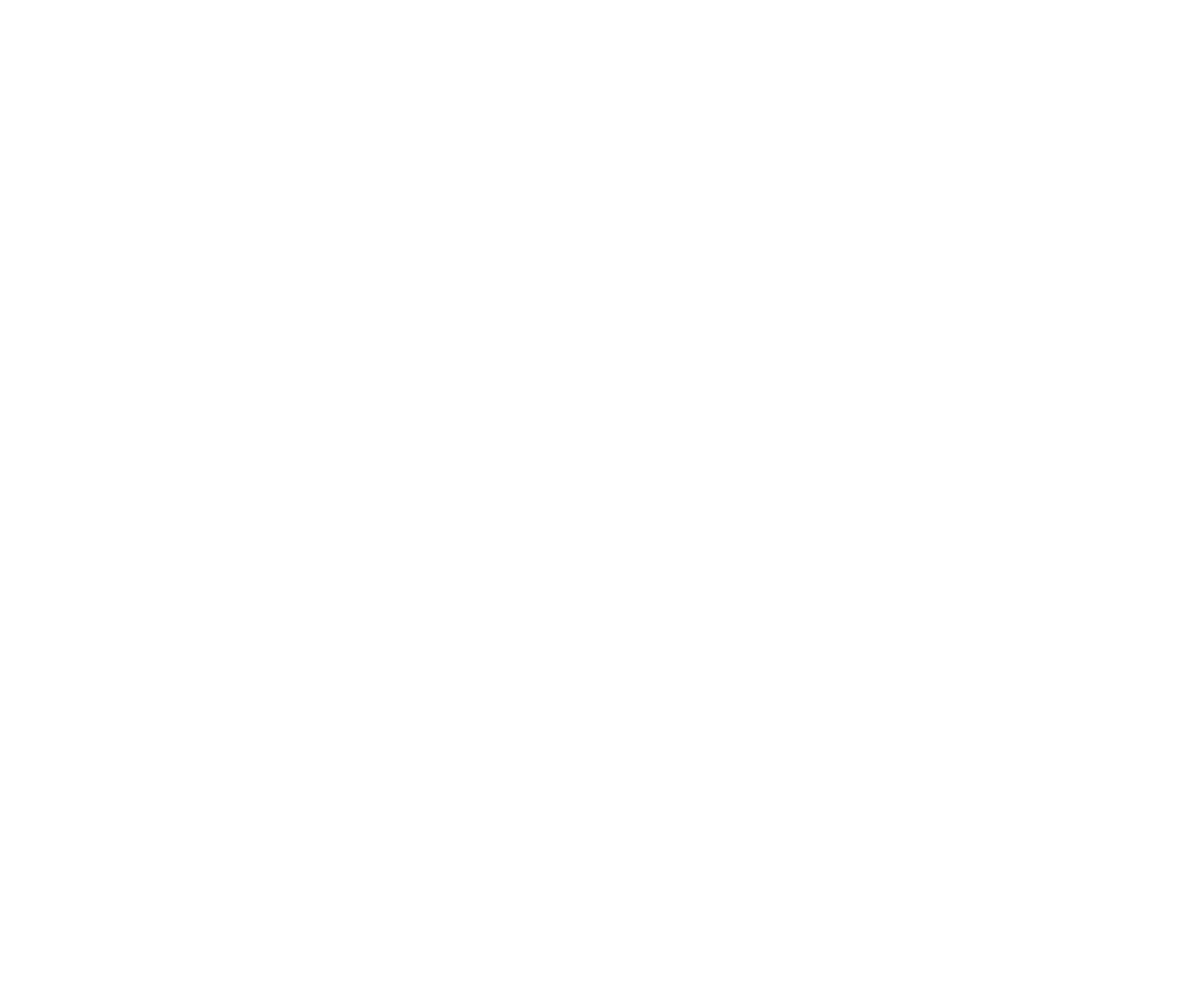

✅ Échantillons d'images générées sauvegardés dans c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs\generated_samples_per_class.png


In [ ]:
## Étape 9 : Visualiser quelques images synthétiques générées par le CycleGAN

print("Vérification des images synthétiques générées par le Class Equalizer...")
print("="*60)

# Parcourir chaque classe pour compter les images augmentées
train_dir_root = os.path.join(StarGAN_dir, "train")
total_generated = 0

for class_idx in range(1, 8):
    class_name = f"type{class_idx}"
    class_path = os.path.join(train_dir_root, class_name)
    aug_images = [f for f in os.listdir(class_path) if f.startswith("aug_gen")]
    if len(aug_images) > 0:
        print(f"  {class_name}: {len(aug_images)} images augmentées")
        total_generated += len(aug_images)

print(f"\nTotal d'images synthétiques générées: {total_generated}")
print("="*60 + "\n")

# Afficher des échantillons d'images générées si disponibles
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()
sample_count = 0

for class_idx in range(1, 8):
    class_name = f"type{class_idx}"
    class_path = os.path.join(train_dir_root, class_name)
    aug_images = [f for f in os.listdir(class_path) if f.startswith("aug_gen")]
    
    if len(aug_images) > 0 and sample_count < 9:
        img_name = aug_images[0]  # Prendre la première image augmentée
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        
        axes[sample_count].imshow(img)
        axes[sample_count].set_title(f"Generated {class_name}")
        axes[sample_count].axis("off")
        sample_count += 1

# Cacher les axes non utilisés
for idx in range(sample_count, 9):
    axes[idx].axis("off")

plt.tight_layout()
sample_output_path = os.path.join(OUTPUT_DIR, "generated_samples_per_class.png")
plt.savefig(sample_output_path, dpi=100, bbox_inches='tight')
plt.show()
print(f"✅ Échantillons d'images générées sauvegardés dans {sample_output_path}")


In [ ]:
## Étape 10 : Appliquer le Class Equalizer et créer le dataset augmenté pour la classification

# Dossier pour le dataset de classification
classification_dataset_dir = os.path.join(StarGAN_dir, "classification_dataset")
os.makedirs(classification_dataset_dir, exist_ok=True)

# Créer les dossiers train/test pour chaque type
for i in range(1, 8):
    os.makedirs(os.path.join(classification_dataset_dir, "train", f"type{i}"), exist_ok=True)
    os.makedirs(os.path.join(classification_dataset_dir, "test", f"type{i}"), exist_ok=True)

print("="*60)
print("🚀 ÉTAPE 10: ÉGALISATION DES CLASSES AVEC LE CYCLEGANG")
print("="*60)

# ============================================================
# 1️⃣ APPLIQUER LE CLASS EQUALIZER
# ============================================================
train_dir_root = os.path.join(StarGAN_dir, "train")
print("\n1️⃣ Application du Class Equalizer...")
class_equalizer(G, train_loader, device, num_domains, train_dir_root, classification_dataset_dir)

# ============================================================
# 2️⃣ COPIER LES IMAGES DE TEST (SANS MODIFICATION)
# ============================================================
print("\n2️⃣ Copie des images de test (sans modification)...")
test_dir_root = os.path.join(StarGAN_dir, "test")
for type_idx in range(1, 8):
    type_name = f"type{type_idx}"
    
    src_test = os.path.join(test_dir_root, type_name)
    dst_test = os.path.join(classification_dataset_dir, "test", type_name)
    
    for img in os.listdir(src_test):
        if img.endswith('.jpg'):
            shutil.copy(os.path.join(src_test, img), os.path.join(dst_test, img))
    
    test_count = len(os.listdir(dst_test))
    print(f"✅ {type_name} - Test: {test_count} images")

print("\n" + "="*60)
print("✨ Dataset de classification créé avec succès!")
print("="*60)


🚀 ÉTAPE 10: ÉGALISATION DES CLASSES AVEC LE CYCLEGANG

1️⃣ Application du Class Equalizer...

🔄 ÉQUILIBRAGE DES CLASSES (CLASS EQUALIZER)
Distribution initiale des images par classe:
  type1: 36 images
  type2: 198 images
  type3: 178 images
  type4: 153 images
  type5: 140 images
  type6: 76 images
  type7: 48 images

📊 Classe avec le plus d'images: 198 images

🎯 Génération pour type1: 162 images manquantes
Images générées pour la classe 0: 162 images
✅ type2: 198 images (maximum atteint)

🎯 Génération pour type3: 20 images manquantes
Images générées pour la classe 2: 20 images

🎯 Génération pour type4: 45 images manquantes
Images générées pour la classe 3: 45 images

🎯 Génération pour type5: 58 images manquantes
Images générées pour la classe 4: 58 images

🎯 Génération pour type6: 122 images manquantes
Images générées pour la classe 5: 122 images

🎯 Génération pour type7: 150 images manquantes
Images générées pour la classe 6: 150 images

✨ VÉRIFICATION FINALE
  type1: 198 images
  t

In [ ]:
## Étape 9.5 : Plan d'augmentation - Nombre d'images à créer par catégorie

print("\n" + "="*70)
print("📋 PLAN D'AUGMENTATION DES IMAGES PAR CATÉGORIE")
print("="*70)

# Récupérer la distribution actuelle des images en train
train_dir_root = os.path.join(StarGAN_dir, "train")
current_distribution = get_class_distribution(train_dir_root)

print("\n📊 DISTRIBUTION ACTUELLE (AVANT AUGMENTATION):")
print("-" * 70)

# Afficher la distribution actuelle et trouver le maximum
max_images = 0
for class_idx in range(1, 8):
    class_name = f"type{class_idx}"
    current_count = current_distribution.get(class_name, 0)
    max_images = max(max_images, current_count)
    soil_types = {
        "type1": "Alluvial Soil",
        "type2": "Arid Soil",
        "type3": "Black Soil",
        "type4": "Laterite Soil",
        "type5": "Mountain Soil",
        "type6": "Red Soil",
        "type7": "Yellow Soil"
    }
    print(f"  {class_name} ({soil_types.get(class_name, 'Unknown')}): {current_count:4d} images")

print("-" * 70)
print(f"🎯 NOMBRE MAXIMUM D'IMAGES PAR CLASSE: {max_images}")

print("\n📈 IMAGES À CRÉER PAR CATÉGORIE (PLAN D'AUGMENTATION):")
print("-" * 70)

# Calculer et afficher le plan d'augmentation
total_to_generate = 0
augmentation_plan = {}

for class_idx in range(1, 8):
    class_name = f"type{class_idx}"
    current_count = current_distribution.get(class_name, 0)
    images_to_create = max_images - current_count
    augmentation_plan[class_name] = images_to_create
    total_to_generate += images_to_create
    
    soil_types = {
        "type1": "Alluvial Soil",
        "type2": "Arid Soil",
        "type3": "Black Soil",
        "type4": "Laterite Soil",
        "type5": "Mountain Soil",
        "type6": "Red Soil",
        "type7": "Yellow Soil"
    }
    
    status = "✅ (Déjà équilibré)" if images_to_create == 0 else "⚠️ (À augmenter)"
    print(f"  {class_name} ({soil_types.get(class_name, 'Unknown'):20s}): "
          f"Créer {images_to_create:3d} images {status}")

print("-" * 70)
print(f"📊 TOTAL À GÉNÉRER: {total_to_generate} images synthétiques")

print("\n📋 RÉSUMÉ FINAL ATTENDU (APRÈS AUGMENTATION):")
print("-" * 70)
print(f"  Chaque classe aura: {max_images} images")
print(f"  Total images en train (équilibré): {max_images * 7} images")
print("="*70 + "\n")



📋 PLAN D'AUGMENTATION DES IMAGES PAR CATÉGORIE

📊 DISTRIBUTION ACTUELLE (AVANT AUGMENTATION):
----------------------------------------------------------------------
  type1 (Alluvial Soil):  198 images
  type2 (Arid Soil):  198 images
  type3 (Black Soil):  198 images
  type4 (Laterite Soil):  198 images
  type5 (Mountain Soil):  198 images
  type6 (Red Soil):  198 images
  type7 (Yellow Soil):  198 images
----------------------------------------------------------------------
🎯 NOMBRE MAXIMUM D'IMAGES PAR CLASSE: 198

📈 IMAGES À CRÉER PAR CATÉGORIE (PLAN D'AUGMENTATION):
----------------------------------------------------------------------
  type1 (Alluvial Soil       ): Créer   0 images ✅ (Déjà équilibré)
  type2 (Arid Soil           ): Créer   0 images ✅ (Déjà équilibré)
  type3 (Black Soil          ): Créer   0 images ✅ (Déjà équilibré)
  type4 (Laterite Soil       ): Créer   0 images ✅ (Déjà équilibré)
  type5 (Mountain Soil       ): Créer   0 images ✅ (Déjà équilibré)
  type6 (R

In [ ]:
## Étape 11 : Créer un dataset et DataLoaders pour la classification

class ClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_to_idx = {}
        self.idx_to_label = {}
        
        # Parcourir les dossiers de classes
        class_dirs = sorted(os.listdir(root_dir))
        for idx, class_name in enumerate(class_dirs):
            self.label_to_idx[class_name] = idx
            self.idx_to_label[idx] = class_name
            
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.endswith('.jpg'):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(idx)
    
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.images)

# Créer les datasets de classification
clf_train_dataset = ClassificationDataset(
    os.path.join(classification_dataset_dir, "train"),
    transform=transform
)
clf_test_dataset = ClassificationDataset(
    os.path.join(classification_dataset_dir, "test"),
    transform=transform
)

# DataLoaders pour la classification
clf_train_loader = DataLoader(
    clf_train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

clf_test_loader = DataLoader(
    clf_test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)

print("\n" + "="*60)
print("📊 RÉSUMÉ DES DATASETS DE CLASSIFICATION")
print("="*60)
print(f"✅ Dataset Train: {len(clf_train_dataset)} images")
print(f"✅ Dataset Test: {len(clf_test_dataset)} images")
print(f"\n🏷️ Classes disponibles: {clf_train_dataset.label_to_idx}")

# Afficher la distribution des classes en train
print("\n📈 Distribution en TRAIN:")
train_dist = get_class_distribution(os.path.join(classification_dataset_dir, "train"))
for class_name, count in sorted(train_dist.items()):
    print(f"  {class_name}: {count} images")

# Afficher la distribution des classes en test
print("\n📉 Distribution en TEST:")
test_dist = get_class_distribution(os.path.join(classification_dataset_dir, "test"))
for class_name, count in sorted(test_dist.items()):
    print(f"  {class_name}: {count} images")
print("="*60 + "\n")



📊 RÉSUMÉ DES DATASETS DE CLASSIFICATION
✅ Dataset Train: 1386 images
✅ Dataset Test: 360 images

🏷️ Classes disponibles: {'type1': 0, 'type2': 1, 'type3': 2, 'type4': 3, 'type5': 4, 'type6': 5, 'type7': 6}

📈 Distribution en TRAIN:
  type1: 198 images
  type2: 198 images
  type3: 198 images
  type4: 198 images
  type5: 198 images
  type6: 198 images
  type7: 198 images

📉 Distribution en TEST:
  type1: 16 images
  type2: 86 images
  type3: 77 images
  type4: 66 images
  type5: 61 images
  type6: 33 images
  type7: 21 images



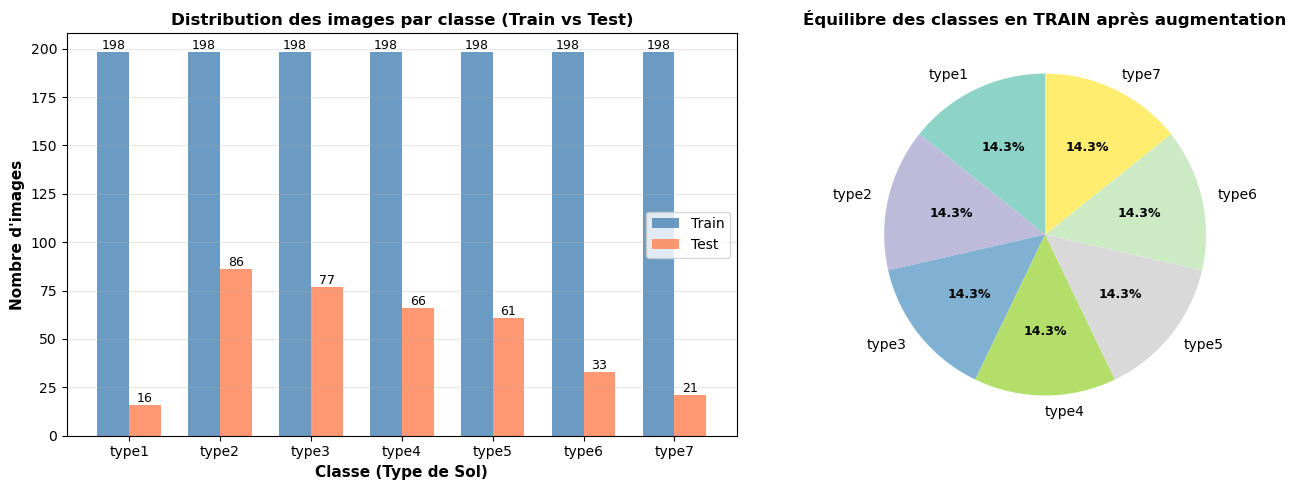


✅ Visualisation de l'équilibre des classes sauvegardée
📁 Fichier sauvegardé: c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs\class_balance_visualization.png
Total images TRAIN: 1386
Total images TEST: 360
Proportion TRAIN/TEST: 1386/360



In [ ]:
## Étape 12 : Visualiser l'équilibre des classes

import matplotlib.pyplot as plt
import numpy as np

# Récupérer les distributions
train_dist = get_class_distribution(os.path.join(classification_dataset_dir, "train"))
test_dist = get_class_distribution(os.path.join(classification_dataset_dir, "test"))

# Préparer les données pour le graphique
class_names = sorted(train_dist.keys())
train_counts = [train_dist[name] for name in class_names]
test_counts = [test_dist[name] for name in class_names]

# Créer le graphique
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Distribution train/test par classe
x = np.arange(len(class_names))
width = 0.35

ax = axes[0]
bars1 = ax.bar(x - width/2, train_counts, width, label='Train', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, test_counts, width, label='Test', alpha=0.8, color='coral')

ax.set_xlabel('Classe (Type de Sol)', fontsize=11, fontweight='bold')
ax.set_ylabel('Nombre d\'images', fontsize=11, fontweight='bold')
ax.set_title('Distribution des images par classe (Train vs Test)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

# Graphique 2: Équilibre de la distribution train
ax = axes[1]
colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
wedges, texts, autotexts = ax.pie(train_counts, labels=class_names, autopct='%1.1f%%',
                                    colors=colors, startangle=90)
ax.set_title('Équilibre des classes en TRAIN après augmentation', fontsize=12, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

plt.tight_layout()
balance_output_path = os.path.join(OUTPUT_DIR, "class_balance_visualization.png")
plt.savefig(balance_output_path, dpi=100, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("✅ Visualisation de l'équilibre des classes sauvegardée")
print("="*60)
print(f"📁 Fichier sauvegardé: {balance_output_path}")
print(f"Total images TRAIN: {sum(train_counts)}")
print(f"Total images TEST: {sum(test_counts)}")
print(f"Proportion TRAIN/TEST: {sum(train_counts)}/{sum(test_counts)}")
print("="*60 + "\n")


In [ ]:
## Résumé Final - Localisation des fichiers générés

print("\n" + "="*70)
print("📁 RÉSUMÉ DE LA STRUCTURE DES FICHIERS GÉNÉRÉS")
print("="*70)

print("\n✅ DOSSIER DE SORTIE PRINCIPAL:")
print(f"   📂 {OUTPUT_DIR}")

print("\n📊 Fichiers générés dans le dossier outputs:")
print("-" * 70)

# Modèles
models_dir = os.path.join(OUTPUT_DIR, "models")
if os.path.exists(models_dir):
    model_files = os.listdir(models_dir)
    print(f"\n🤖 Modèles ({len(model_files)} fichiers):")
    for f in sorted(model_files):
        file_path = os.path.join(models_dir, f)
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # Taille en MB
        print(f"   • {f} ({file_size:.2f} MB)")

# Samples
samples_dir = os.path.join(OUTPUT_DIR, "samples")
if os.path.exists(samples_dir):
    sample_files = os.listdir(samples_dir)
    print(f"\n🖼️  Samples ({len(sample_files)} fichiers):")
    for f in sorted(sample_files):
        print(f"   • {f}")

# Logs
logs_dir = os.path.join(OUTPUT_DIR, "training_logs")
if os.path.exists(logs_dir):
    log_files = os.listdir(logs_dir)
    print(f"\n📈 Logs TensorBoard ({len(log_files)} fichier(s)):")
    for f in sorted(log_files):
        print(f"   • {f}")

# Visualisations
viz_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')]
if viz_files:
    print(f"\n📊 Visualisations ({len(viz_files)} fichier(s)):")
    for f in sorted(viz_files):
        print(f"   • {f}")

print("\n" + "="*70)
print("✨ RÉSUMÉ DES DOSSIERS DE DONNÉES:")
print("-" * 70)
print(f"\n📂 Données originales: ../data/StarGAN-Dataset/")
print(f"📂 Dataset de classification: {classification_dataset_dir}")
print(f"📂 Outputs générés: {OUTPUT_DIR}")

print("\n" + "="*70)
print("🎯 COMMENT ACCÉDER AUX FICHIERS:")
print("-" * 70)
print(f"\n1️⃣  Pour voir les modèles entraînés:")
print(f"   → Naviguez vers: {models_dir}")
print(f"\n2️⃣  Pour voir les logs TensorBoard:")
print(f"   → Exécutez: tensorboard --logdir={logs_dir}")
print(f"\n3️⃣  Pour voir les visualisations:")
print(f"   → Naviguez vers: {OUTPUT_DIR}")
print(f"\n4️⃣  Pour voir les samples générés:")
print(f"   → Naviguez vers: {samples_dir}")

print("\n" + "="*70 + "\n")



📁 RÉSUMÉ DE LA STRUCTURE DES FICHIERS GÉNÉRÉS

✅ DOSSIER DE SORTIE PRINCIPAL:
   📂 c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs

📊 Fichiers générés dans le dossier outputs:
----------------------------------------------------------------------

🤖 Modèles (2 fichiers):
   • D_epoch_0.pth (0.15 MB)
   • G_epoch_0.pth (1.50 MB)

🖼️  Samples (1 fichiers):
   • epoch_0.png

📈 Logs TensorBoard (4 fichier(s)):
   • 20260119-142655
   • 20260119-142742
   • 20260119-143111
   • 20260119-143410

📊 Visualisations (2 fichier(s)):
   • class_balance_visualization.png
   • generated_samples_per_class.png

✨ RÉSUMÉ DES DOSSIERS DE DONNÉES:
----------------------------------------------------------------------

📂 Données originales: ../data/Renamed-Dataset/
📂 Dataset de classification: ../data/Renamed-Dataset\classification_dataset
📂 Outputs générés: c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for 

🧠 CNN SIMPLE POUR CLASSIFICATION DES TYPES DE SOL
Modèle: SimpleCNN
Nombre de classes: 7
Device: cpu
Dataset train: 1386 images
Dataset test: 360 images

🚀 Début de l'entraînement…



Epoch 1/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch  1/20 | Train Loss: 4.1292 | Train Acc:  44.52% | Test Loss: 1.0769 | Test Acc:  56.94%


Epoch 2/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch  2/20 | Train Loss: 1.1992 | Train Acc:  56.42% | Test Loss: 0.9625 | Test Acc:  63.89%


Epoch 3/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch  3/20 | Train Loss: 1.1524 | Train Acc:  58.08% | Test Loss: 0.9597 | Test Acc:  65.28%


Epoch 4/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch  4/20 | Train Loss: 1.0497 | Train Acc:  60.46% | Test Loss: 0.8671 | Test Acc:  64.44%


Epoch 5/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch  5/20 | Train Loss: 1.0385 | Train Acc:  60.46% | Test Loss: 0.9499 | Test Acc:  65.83%


Epoch 6/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch  6/20 | Train Loss: 0.9659 | Train Acc:  63.78% | Test Loss: 0.8058 | Test Acc:  70.28%


Epoch 7/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch  7/20 | Train Loss: 0.9817 | Train Acc:  63.20% | Test Loss: 0.8296 | Test Acc:  69.44%


Epoch 8/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch  8/20 | Train Loss: 0.9123 | Train Acc:  64.00% | Test Loss: 0.7405 | Test Acc:  73.61%


Epoch 9/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch  9/20 | Train Loss: 0.9485 | Train Acc:  63.92% | Test Loss: 0.8000 | Test Acc:  68.61%


Epoch 10/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.8601 | Train Acc:  67.82% | Test Loss: 0.7253 | Test Acc:  72.50%


Epoch 11/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.8586 | Train Acc:  69.12% | Test Loss: 0.7947 | Test Acc:  75.28%


Epoch 12/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.9176 | Train Acc:  64.86% | Test Loss: 0.7550 | Test Acc:  74.44%


Epoch 13/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.8911 | Train Acc:  66.81% | Test Loss: 0.7246 | Test Acc:  71.11%


Epoch 14/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.8748 | Train Acc:  68.76% | Test Loss: 0.7449 | Test Acc:  70.83%


Epoch 15/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.9016 | Train Acc:  65.15% | Test Loss: 0.7525 | Test Acc:  75.56%


Epoch 16/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 1.0377 | Train Acc:  62.55% | Test Loss: 0.6933 | Test Acc:  74.72%


Epoch 17/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.9346 | Train Acc:  66.59% | Test Loss: 0.7322 | Test Acc:  74.17%


Epoch 18/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.8423 | Train Acc:  67.24% | Test Loss: 0.6714 | Test Acc:  77.22%


Epoch 19/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.8248 | Train Acc:  67.32% | Test Loss: 0.8915 | Test Acc:  71.11%


Epoch 20/20 [TRAIN]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.8368 | Train Acc:  69.48% | Test Loss: 0.7100 | Test Acc:  75.56%

✅ Entraînement terminé !



c:\Users\maxde\anaconda3\envs\dldna\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maxde\anaconda3\envs\dldna\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maxde\anaconda3\envs\dldna\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\User

📊 RÉSULTATS FINAUX

Accuracy globale: 0.7556 (75.56%)

Classification Report:
              precision    recall  f1-score   support

       type1       0.00      0.00      0.00        16
       type2       0.66      0.70      0.68        86
       type3       0.93      0.88      0.91        77
       type4       0.77      0.71      0.74        66
       type5       0.65      0.79      0.71        61
       type6       0.79      0.94      0.86        33
       type7       0.82      0.86      0.84        21

    accuracy                           0.76       360
   macro avg       0.66      0.70      0.68       360
weighted avg       0.73      0.76      0.74       360


💾 Modèle sauvegardé: c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs\simple_cnn_classifier.pth


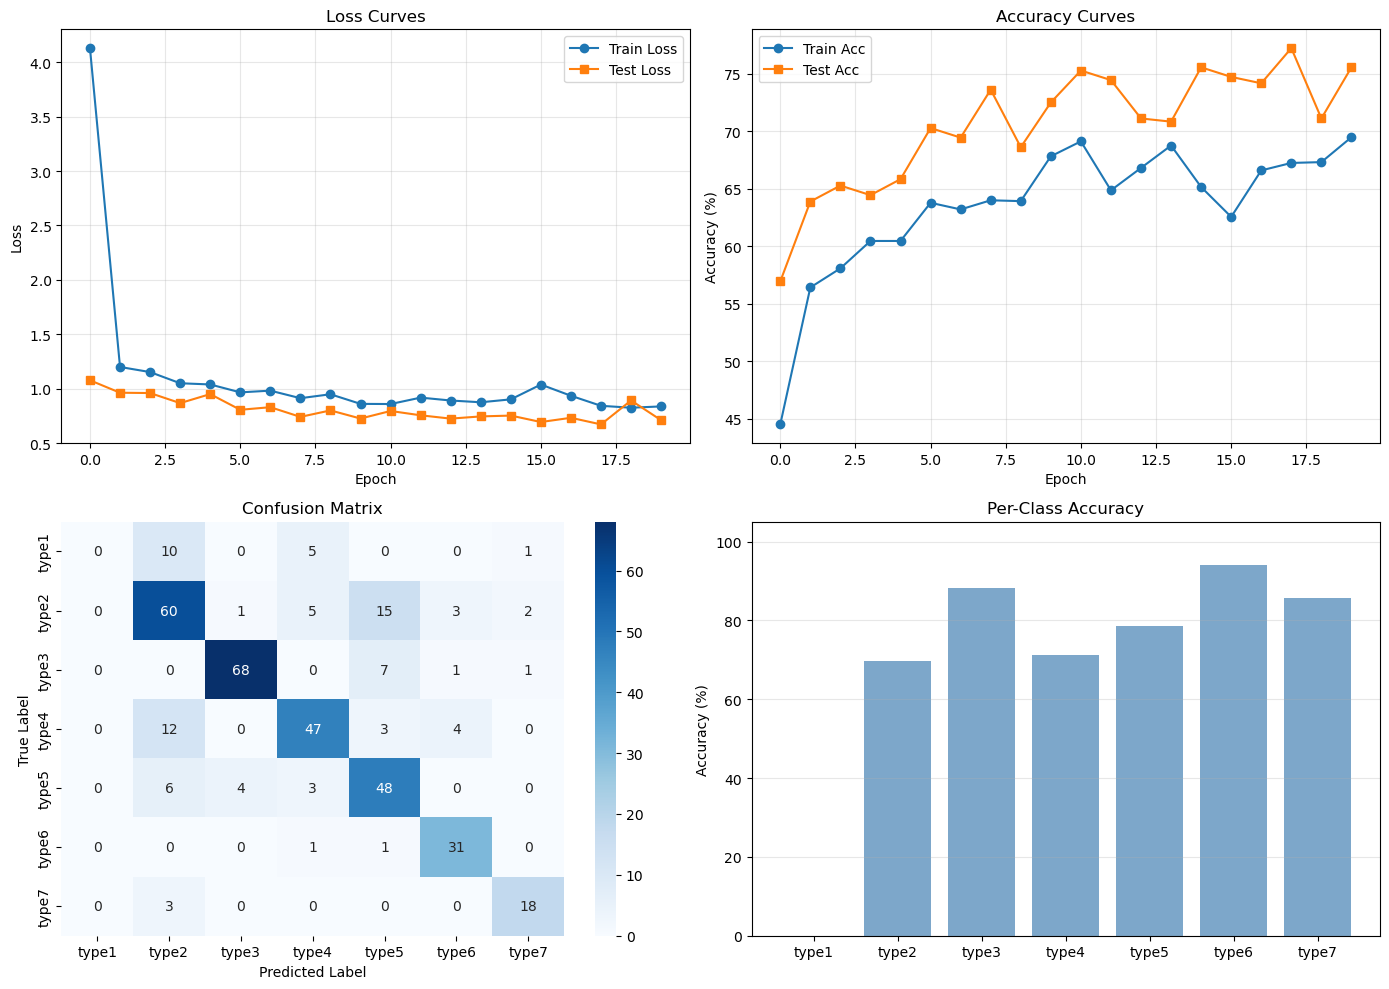


📈 Visualisations sauvegardées: c:\Users\maxde\Desktop\Cours\ENTPE 3e année\Data Science\Deep Learning for Dynamic Network Analysis\DLNA_project\outputs\cnn_evaluation.png




In [ ]:
## Étape 13 : CNN Simple pour tester les résultats

import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# ============================================================
# 1️⃣ DÉFINIR UN CNN SIMPLE
# ============================================================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# ============================================================
# 2️⃣ INITIALISER LE MODÈLE
# ============================================================
num_classes = 7
cnn_model = SimpleCNN(num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

print("=" * 70)
print("🧠 CNN SIMPLE POUR CLASSIFICATION DES TYPES DE SOL")
print("=" * 70)
print(f"Modèle: {cnn_model.__class__.__name__}")
print(f"Nombre de classes: {num_classes}")
print(f"Device: {device}")
print(f"Dataset train: {len(clf_train_dataset)} images")
print(f"Dataset test: {len(clf_test_dataset)} images\n")


# ============================================================
# 3️⃣ ENTRAÎNER LE CNN
# ============================================================
num_epochs_cnn = 20
train_losses, test_losses = [], []
train_accs, test_accs = [], []

print("🚀 Début de l'entraînement…\n")

for epoch in range(num_epochs_cnn):
    # --- TRAIN ---
    cnn_model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    
    with tqdm(clf_train_loader, desc=f"Epoch {epoch+1}/{num_epochs_cnn} [TRAIN]", leave=False) as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item()})
    
    train_loss /= len(clf_train_loader)
    train_acc = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # --- TEST ---
    cnn_model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    
    with torch.no_grad():
        for images, labels in clf_test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn_model(images)
            loss = loss_fn(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_loss /= len(clf_test_loader)
    test_acc = 100 * test_correct / test_total
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs_cnn} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:6.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:6.2f}%")


print("\n" + "=" * 70)
print("✅ Entraînement terminé !")
print("=" * 70 + "\n")


# ============================================================
# 4️⃣ ÉVALUATION FINALE
# ============================================================
cnn_model.eval()
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for images, labels in clf_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

# Métriques
final_accuracy = accuracy_score(all_labels, all_predictions)
report = classification_report(all_labels, all_predictions, 
                               target_names=[f"type{i+1}" for i in range(num_classes)],
                               output_dict=True)

print("📊 RÉSULTATS FINAUX\n")
print(f"Accuracy globale: {final_accuracy:.4f} ({100*final_accuracy:.2f}%)\n")
print("Classification Report:")
print(classification_report(all_labels, all_predictions, 
                           target_names=[f"type{i+1}" for i in range(num_classes)]))

# Sauvegarder le modèle
model_path = os.path.join(OUTPUT_DIR, "simple_cnn_classifier.pth")
torch.save(cnn_model.state_dict(), model_path)
print(f"\n💾 Modèle sauvegardé: {model_path}")


# ============================================================
# 5️⃣ VISUALISATIONS
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', marker='o')
axes[0, 0].plot(test_losses, label='Test Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Curves')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(train_accs, label='Train Acc', marker='o')
axes[0, 1].plot(test_accs, label='Test Acc', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Accuracy Curves')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=[f"type{i+1}" for i in range(num_classes)],
            yticklabels=[f"type{i+1}" for i in range(num_classes)])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# Per-class accuracy
class_accs = []
for i in range(num_classes):
    mask = all_labels == i
    if mask.sum() > 0:
        class_acc = (all_predictions[mask] == all_labels[mask]).sum() / mask.sum()
        class_accs.append(class_acc)
    else:
        class_accs.append(0)

axes[1, 1].bar([f"type{i+1}" for i in range(num_classes)], 
               [100*acc for acc in class_accs], 
               color='steelblue', alpha=0.7)
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Per-Class Accuracy')
axes[1, 1].set_ylim([0, 105])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
viz_path = os.path.join(OUTPUT_DIR, "cnn_evaluation.png")
plt.savefig(viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"\n📈 Visualisations sauvegardées: {viz_path}\n")
print("=" * 70 + "\n")
